# classfication

# 准备数据

In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([transforms.ToTensor()])#ToTensor将数据转换为张量，并归一化到0-1之间
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_dataset[0]
train_dataset[0][0].shape #1*28*28的ndarray

torch.Size([1, 28, 28])

In [7]:
type(train_dataset)

torchvision.datasets.mnist.FashionMNIST

In [8]:
# 获取图像和标签
train_images = train_dataset.data.numpy() 
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称，0-9修改为英文
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")
train_images[0] #28*28的ndarray

train_labels[0:5]

训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


array([9, 0, 0, 3, 0], dtype=int64)

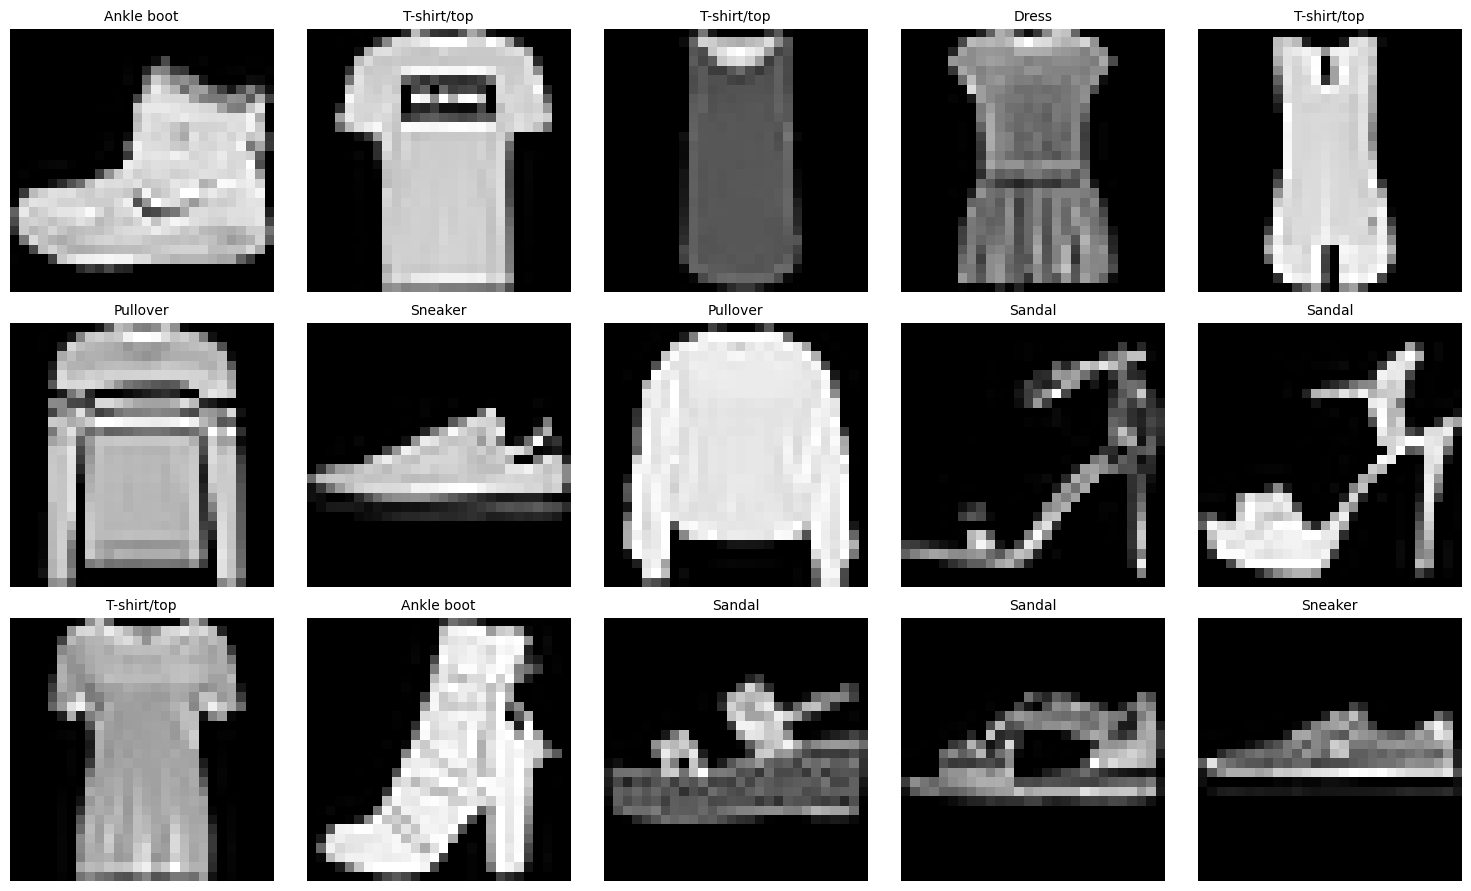

In [9]:
# 导入matplotlib用于绘图
import matplotlib.pyplot as plt
import matplotlib


# 创建一个3行5列的图表来显示前15个样本
plt.figure(figsize=(15, 9))  # 设置图表大小

# 遍历前15个样本
for i in range(15):
    # 创建子图
    plt.subplot(3, 5, i + 1)
    
    # 显示图像
    plt.imshow(train_images[i], cmap='gray')
    
    # 添加标题（显示类别名称）
    plt.title(class_names[train_labels[i]], fontsize=10)
    
    # 关闭坐标轴
    plt.axis('off')

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

# 数据集划分训练，验证以及设置3个加载器

In [10]:
# 设置随机种子以确保结果可复现
torch.manual_seed(42)

# 定义设备（GPU/CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 划分数据集为训练集和验证集
train_size = 55000
val_size = 5000

# 使用torch.utils.data.random_split函数接口划分数据集
train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size, val_size]
)

print(f"训练集大小: {train_size}")
print(f"验证集大小: {val_size}")

# 创建数据加载器
batch_size = 64  # 批次大小

# torch.utils.data.DataLoader是PyTorch提供的一个数据加载器，用于将数据集划分为多个批次，并进行随机打乱和并行加载

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # 打乱数据
    num_workers=2,  # 多进程加载数据
    pin_memory=True  # 将数据加载到CUDA固定内存中，加速GPU训练
)

# 验证数据加载器
val_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # 验证集不需要打乱
    num_workers=2,
    pin_memory=True
)
# 测试数据加载器
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)



训练集大小: 55000
验证集大小: 5000


# 定义并搭建模型

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# 检查CUDA是否可用，如果可用则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

class NeuralNetwork(nn.Module):
    # 定义神经网络的结构
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # 输入层 -> 第一隐藏层 (28*28=784 -> 300)
            nn.Linear(28 * 28, 300),  # in_features=784, out_features=300
            nn.ReLU(),
            # 第一隐藏层 -> 第二隐藏层 (300 -> 100)
            nn.Linear(300, 100),
            nn.ReLU(),
            # 第二隐藏层 -> 输出层 (100 -> 10，对应10个数字类别)
            nn.Linear(100, 10),
        )

    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10],等价与x = self.fc3(x)
        return logits

# 创建神经网络实列化模型
model = NeuralNetwork()
# 将模型移动到指定设备上
model = model.to(device)

# 从train_loader获取第一个批次的数据，dataiter是迭代器，images和labels是批次数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)

# 选择第一张图像进行前向传播测试,unsqueeze(0)是添加批次维度
test_image = images[0].unsqueeze(0).to(device)  # 添加批次维度并移动到设备上
print("测试图像形状:", test_image.shape)

print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(test_image)

# 获取预测结果
_, predicted = torch.max(outputs, 1)
print("模型预测结果:", predicted.item())
print("实际标签:", labels[0].item())

使用设备: cpu


d:\python\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
测试图像形状: torch.Size([1, 1, 28, 28])
----------------------------------------------------------------------------------------------------
模型预测结果: 2
实际标签: 7


# 计算参数量

In [12]:
# 计算模型的总参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {total_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

模型总参数量: 266610

各层参数量明细:
linear_relu_stack.0.weight: 235200 参数
linear_relu_stack.0.bias: 300 参数
linear_relu_stack.2.weight: 30000 参数
linear_relu_stack.2.bias: 100 参数
linear_relu_stack.4.weight: 1000 参数
linear_relu_stack.4.bias: 10 参数


# 封装多个类如早停，保存模型，tensorboard 可视化

In [30]:
import os
class ModelSaver:
    """
    模型保存类：根据配置保存模型权重
    
    参数:
        save_dir: 模型保存目录
        save_best_only: 是否只保存最佳模型
        verbose: 是否打印保存信息
    """
    def __init__(self, save_dir='model_weights', save_best_only=True):
        self.save_dir = save_dir
        self.save_best_only = save_best_only #是否只保存最佳模型
        self.best_score = None #最佳验证准确率
        
        # 确保保存目录存在

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir) #创建保存目录
            
    def __call__(self, model, epoch, val_acc):
        """
        保存模型
        
        参数:
            model: 需要保存的模型
            epoch: 当前训练轮数
            val_acc: 当前验证准确率
        """
        # 生成文件名
        filename = f'model_epoch_{epoch}_acc_{val_acc:.4f}.pth'
        save_path = os.path.join(self.save_dir, filename)
        
        # 是否仅保存最佳模型
        if self.save_best_only:
            # 首次调用或验证准确率提高时保存
            if self.best_score is None or val_acc > self.best_score:
                self.best_score = val_acc
                torch.save(model.state_dict(), save_path)
                
                # 删除之前的最佳模型
                for old_file in os.listdir(self.save_dir):
                    if old_file != filename and old_file.endswith('.pth'):
                        os.remove(os.path.join(self.save_dir, old_file))
        else:
            # 每个epoch都保存
            torch.save(model.state_dict(), save_path)


class EarlyStopping:
    """
    早停类：当验证集准确率在一定轮数内不再提高时，停止训练
    
    参数:
        patience: 容忍验证集准确率不提升的轮数
        delta: 判定准确率是否提升的阈值
        verbose: 是否打印早停信息
    """
    def __init__(self, patience=5, delta=0, verbose=True):
        self.patience = patience #容忍验证集准确率不提升的轮数
        self.delta = delta #判定准确率是否提升的阈值
        self.counter = 0 #记录验证准确率没有提升的轮数
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_acc):
        score = val_acc
        
        # 首次调用时初始化第一次得到的验证准确率
        if self.best_score is None:
            self.best_score = score
            return
        
        # 如果验证准确率没有提升
        if score <= self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience: #如果验证准确率没有提升的轮数大于等于容忍验证集准确率不提升的轮数，则早停
                self.early_stop = True
                print(f"早停触发! 最佳验证准确率: {self.best_score:.4f}")
        # 如果验证准确率提升了
        else:
            self.best_score = score #更新最佳验证准确率
            self.counter = 0


In [31]:
from torch.utils.tensorboard import SummaryWriter
class TensorboardLogger:
    """
    Tensorboard日志记录类：记录训练过程中的损失和准确率
    
    参数:
        log_dir: 日志保存目录
    """
    def __init__(self, log_dir='tensorboard_logs'):

        import os
        
        # 确保日志目录存在
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
            
        self.writer = SummaryWriter(log_dir) # 实例化SummaryWriter, log_dir是log存放路径，flush_secs是每隔多少秒写入磁盘
        
    def log_training(self, epoch, train_loss, train_acc):
        """
        记录训练数据
        
        参数:
            epoch: 当前训练轮数
            train_loss: 训练损失
            train_acc: 训练准确率
        """
        self.writer.add_scalar('训练/损失', train_loss, epoch)
        self.writer.add_scalar('训练/准确率', train_acc, epoch)
        
    def log_validation(self, epoch, val_loss, val_acc):
        """
        记录验证数据
        
        参数:
            epoch: 当前训练轮数
            val_loss: 验证损失
            val_acc: 验证准确率
        """
        self.writer.add_scalar('验证/损失', val_loss, epoch)
        self.writer.add_scalar('验证/准确率', val_acc, epoch)
    
    def log_lr(self, epoch, lr):
        """
        记录学习率
        
        参数:
            epoch: 当前训练轮数
            lr: 学习率
        """
        self.writer.add_scalar('学习率', lr, epoch)
        
    def log_model_graph(self, model, images):
        """
        记录模型结构图
        
        参数:
            model: 模型
            images: 输入图像样本
        """
        self.writer.add_graph(model, images)
        
    def close(self):
        """
        关闭Tensorboard写入器
        """
        self.writer.close()


# 分类设置交叉熵损失函数，SGD优化器

In [32]:
# 设置优化器 - SGD（随机梯度下降）
# 参数:
# - model.parameters(): 需要优化的参数
# - lr: 学习率，控制每次参数更新的步长
# - momentum: 动量因子，帮助加速收敛并减少震荡
# - weight_decay: L2正则化系数，防止过拟合
model = NeuralNetwork()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

print("损失函数:", loss_fn)
print("优化器:", optimizer)


损失函数: CrossEntropyLoss()
优化器: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


# 编写评估函数

In [33]:
def evaluate(model, data_loader, device, criterion=None):
    """
    评估模型在给定数据集上的准确率和损失
    
    参数:
        model: 需要评估的模型
        data_loader: 数据加载器
        device: 计算设备(CPU/GPU)
        criterion: 损失函数（可选）
    
    返回:
        accuracy: 模型准确率
        avg_loss: 平均损失（如果提供了损失函数）
    """
    model.eval()  # 设置为评估模式
    correct = 0 #预测正确样本数
    total = 0 #总样本数
    running_loss = 0.0 #总损失
    
    with torch.no_grad():  # 不计算梯度
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) #torch.max(outputs.data, 1)返回两个值，第一个是最大值，第二个是最大值的索引
            total += labels.size(0) #labels.size(0)返回标签的维度，这里返回的是batch_size，因为每个批次有batch_size个标签
            correct += (predicted == labels).sum().item() #(predicted == labels).sum().item()返回预测正确的标签的个数
            
            # 如果提供了损失函数，计算损失
            if criterion is not None:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0) #loss.item()返回损失值，images.size(0)返回每个批次的样本数量
    
    accuracy = 100 * correct / total #计算准确率

    
    # 如果计算了损失，返回平均损失
    if criterion is not None:
        avg_loss = running_loss / total
        return accuracy, avg_loss
    
    return accuracy

# 训练函数

In [34]:
from tqdm.auto import tqdm
def train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device, 
    num_epochs=10, 
    tensorboard_logger=None,
    model_saver=None,
    early_stopping=None,
    eval_step=200
):
    """
    基于tqdm的训练函数，与training函数类似
    
    参数:
        model: 要训练的模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 训练设备
        num_epochs: 训练轮次
        tensorboard_callback: Tensorboard回调函数
        model_saver: 保存检查点回调函数
        early_stopping: 早停回调函数
        eval_step: 每多少步评估一次
    
    返回:
        record_dict: 包含训练和验证记录的字典
    """
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=num_epochs * len(train_loader)) as pbar:
        for epoch_id in range(num_epochs):
            # 训练
            for datas, labels in train_loader:
                datas = datas.to(device)  # 数据放到device上
                labels = labels.to(device)  # 标签放到device上
                
                # 梯度清空
                optimizer.zero_grad()
                
                # 模型前向计算
                logits = model(datas)
                
                # 计算损失
                loss = criterion(logits, labels)
                
                # 梯度回传，计算梯度
                loss.backward()
                
                # 更新模型参数
                optimizer.step()
                
                # 计算准确率
                preds = logits.argmax(axis=-1)
                acc = (preds == labels).float().mean().item() * 100
                loss_value = loss.cpu().item()
                
                # 记录训练数据
                record_dict["train"].append({
                    "loss": loss_value, "acc": acc, "step": global_step
                })
                
                # 评估
                if global_step % eval_step == 0:
                    val_acc, val_loss = evaluate(model, val_loader, device,criterion)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()  # 切换回训练集模式
                    

                    # 如果有Tensorboard记录器，记录训练和验证指标
                    if tensorboard_logger is not None:
                        tensorboard_logger.log_training(global_step,loss_value,acc)
                        tensorboard_logger.log_validation(global_step,val_loss,val_acc)
                    
                    # 保存模型权重
                    # 如果有模型保存器，保存模型
                    if model_saver is not None:
                        model_saver(model, val_acc, epoch_id)
                    
                    # 如果有早停器，检查是否应该早停
                    if early_stopping is not None:
                        early_stopping(val_acc)
                        if early_stopping.early_stop:
                            print(f'早停: 已有{early_stopping.patience}轮验证损失没有改善！')
                            return model,record_dict
                            
                # 更新步骤
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id, "loss": f"{loss_value:.4f}", "acc": f"{acc:.2f}%"})
    
    return model,record_dict


In [28]:
# 要先运行下面的代码后才能重新定义模型，需要编写模型结构
model = NeuralNetwork()

# 设置优化器 - SGD（随机梯度下降）
# 参数:
# - model.parameters(): 需要优化的参数
# - lr: 学习率，控制每次参数更新的步长
# - momentum: 动量因子，帮助加速收敛并减少震荡
# - weight_decay: L2正则化系数，防止过拟合
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
# 1. 搭建模型并实列化对象
# 2 .定义损失函数 采用交叉熵损失函数并定义优化器 采用SGD
# 3. 编写评估函数
# 4. 编写训练函数



In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5,delta=0.001) #早停
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True) #保存最好的模型
tensorboard_logger=TensorboardLogger(log_dir='logs') #tensorboard日志

model, history = train_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50,early_stopping=early_stopping,model_saver=model_saver,tensorboard_logger=tensorboard_logger)



使用设备: cpu


  0%|          | 0/9380 [00:00<?, ?it/s]

d:\python\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


早停触发! 最佳验证准确率: 89.1000
早停: 已有5轮验证损失没有改善！


In [36]:
history['train'][-100:-1]

[{'loss': 0.3972179889678955, 'acc': 87.5, 'step': 6501},
 {'loss': 0.21716804802417755, 'acc': 92.1875, 'step': 6502},
 {'loss': 0.3864675462245941, 'acc': 87.5, 'step': 6503},
 {'loss': 0.3376970589160919, 'acc': 85.9375, 'step': 6504},
 {'loss': 0.2079056203365326, 'acc': 89.0625, 'step': 6505},
 {'loss': 0.2734352648258209, 'acc': 92.1875, 'step': 6506},
 {'loss': 0.31504955887794495, 'acc': 87.5, 'step': 6507},
 {'loss': 0.31265923380851746, 'acc': 90.625, 'step': 6508},
 {'loss': 0.19150499999523163, 'acc': 95.3125, 'step': 6509},
 {'loss': 0.3293333947658539, 'acc': 85.9375, 'step': 6510},
 {'loss': 0.15198001265525818, 'acc': 96.875, 'step': 6511},
 {'loss': 0.2105793058872223, 'acc': 92.1875, 'step': 6512},
 {'loss': 0.3231600522994995, 'acc': 89.0625, 'step': 6513},
 {'loss': 0.23004043102264404, 'acc': 90.625, 'step': 6514},
 {'loss': 0.2537250518798828, 'acc': 89.0625, 'step': 6515},
 {'loss': 0.44832921028137207, 'acc': 87.5, 'step': 6516},
 {'loss': 0.3287774920463562, 'a

In [45]:
history['val'][-10:-1]

[{'loss': 0.31702735831737516, 'acc': 88.32, 'step': 4800},
 {'loss': 0.30588943403959273, 'acc': 88.64, 'step': 5000},
 {'loss': 0.3450247756242752, 'acc': 87.08, 'step': 5200},
 {'loss': 0.3177541727900505, 'acc': 88.14, 'step': 5400},
 {'loss': 0.29903991632461546, 'acc': 89.1, 'step': 5600},
 {'loss': 0.3391580809354782, 'acc': 87.3, 'step': 5800},
 {'loss': 0.328084964799881, 'acc': 87.64, 'step': 6000},
 {'loss': 0.29243693079948424, 'acc': 89.1, 'step': 6200},
 {'loss': 0.30496583960056306, 'acc': 88.8, 'step': 6400}]

In [28]:
# 1. tensorboard 可视化
# tensorboard_callback = TensorBoardCallback("runs")
# tensorboard_callback.draw_model(model, [1, 28, 28]) #画模型结构图
# 2. save best
# save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)
# 3. early stop
# early_stop_callback = EarlyStopCallback(patience=5)

# 绘制损失曲线和准确率曲线

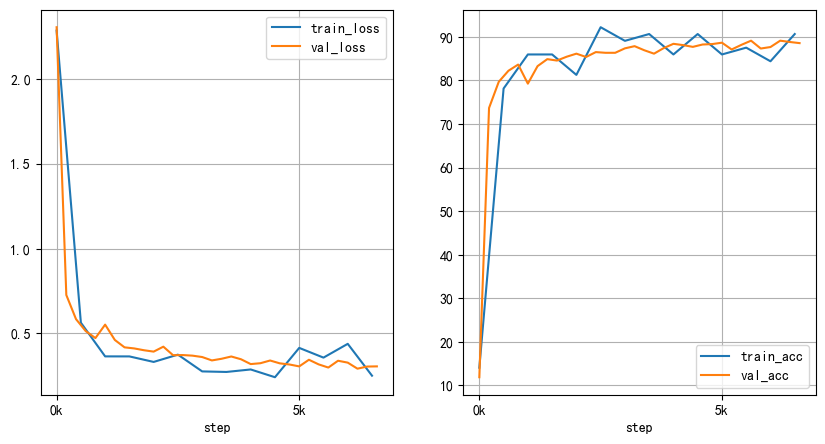

In [42]:
import pandas as pd
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves1(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    # print(train_df.head())
    # print(val_df.head())
    # plot
    fig_num = len(train_df.columns) #因为有loss和acc两个指标，所以画个子图
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5)) #fig_num个子图，figsize是子图大小
    for idx, item in enumerate(train_df.columns):    
        #index是步数，item是指标名字
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        x_data=range(0, train_df.index[-1], 5000) #每隔5000步标出一个点
        axs[idx].set_xticks(x_data)
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", x_data)) #map生成labal
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves1(history, sample_step=500)  #横坐标是 steps

In [43]:
# 在测试集上评估模型
test_accuracy = evaluate(model, test_loader, device)
test_accuracy

87.18